In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
from collections import Counter

### Read data

In [2]:
raw = pd.read_csv('./5-scalar_mturk_results_round-3.csv')

### Flatten data

In [3]:
data = []
for i,row in raw.iterrows():
    for j in range(1, 13):
        query = row['Input.q%d' % j]
        response = row['Input.r%d' % j]
        gender = row['Input.g%d' % j]
        
        if row['Answer.answer%d' % j] is not np.nan:
            answer = row['Answer.answer%d' % j]
        else:
            answer = row['Answer.answer%d.label' % j]
        
        data.append((row['HITId'], j, row['WorkerId'], gender, query, response, answer))

In [4]:
melted = pd.DataFrame(data)
melted.columns = ['HITId', 'q_idx', 'WorkerId', 'gender', 'query', 'response', 'answer']
melted.head(1)

,HITId,q_idx,WorkerId,gender,query,response,answer
0,3511RHPADVF61W71U81691HIKLPRL4,1,A1I66SKK9RFQSA,W,What are your eating habits like?,I eat a lot of chicken.,Very helpful


In [5]:
# include spammers:
include = True
if not include:
    spammers = ['A3A0RP6IUR41PP']
    melted = melted[melted.WorkerId.isin(spammers)].copy()

In [6]:
data = []
for i, group in melted.groupby(['HITId', 'q_idx']):
    row = []
    row.append(group.iloc[0]['HITId'])
    row.append(group.iloc[0]['gender'])
    row.append(group.iloc[0]['query'])
    row.append(group.iloc[0]['response'])
    for j in range(0,2):
        if j < len(group):
            row.append(group.iloc[j]['WorkerId'])
            row.append(group.iloc[j]['answer'])
    data.append(row)

In [7]:
flat = pd.DataFrame(data)
flat.columns = ['HITId', 'gender', 'query', 'response'] + \
    sum([ ['WorkerId%d' % i, 'answer%d' % i] for i in range(0,2) ], [])

In [8]:
flat.head(1)

,HITId,gender,query,response,WorkerId0,answer0,WorkerId1,answer1
0,307L9TDWJYT46UPKVVGP4VIRJ29N3Y,W,What are you willing to risk?,I'm not sure. I think that I will be able to a...,A30NGIKN7761QK,Unhelpful,A3A0RP6IUR41PP,Helpful


### Collapse labels

In [9]:
flat.answer0.unique()

array(['Unhelpful', 'Very helpful', 'Helpful', 'Neutral',
       'Very Unhelpful'], dtype=object)

In [10]:
def mapping(x):
    if type(x) == str:
        x = x.lower()
        l = ['very helpful', 'helpful', 'neutral', 'unhelpful', 'very unhelpful']
        return 4 - l.index(x)
    else:
        print('error')
        return 2

In [11]:
melted['scale'] = melted.answer.apply(lambda x: mapping(x))

### Analysis

In [12]:
groups = melted.groupby('gender').scale.mean()
print(groups)
difference = groups['W'] - groups['M']
print(difference)

gender
M    2.876374
W    3.030899
Name: scale, dtype: float64
0.15452525003086803


In [13]:
melted.std()['scale']

1.0913711657728782

##### Plot

<AxesSubplot:xlabel='gender', ylabel='scale'>

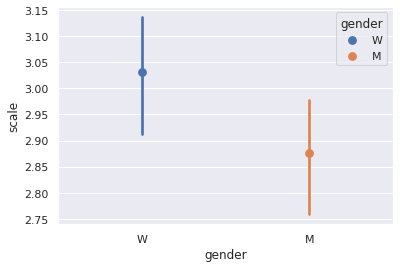

In [14]:
sns.pointplot(x='gender', y='scale', data=melted, hue='gender')

##### t-test

In [15]:
from scipy.stats import ttest_ind
groups = list(melted.groupby('gender'))
m_group, w_group = groups[0], groups[1]
ttest_ind(m_group[1]['scale'], w_group[1]['scale'])

Ttest_indResult(statistic=-1.9029466838319553, pvalue=0.0574472289257883)

##### Number of workers

/nas/home/jwei/anaconda3/envs/notebook/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


8


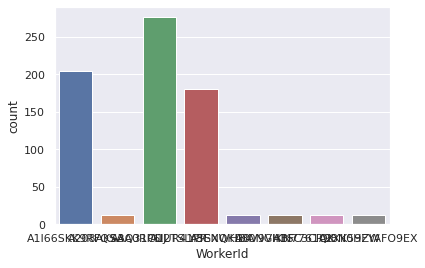

In [16]:
sns.countplot(melted['WorkerId'], orient='v')
print(len(melted['WorkerId'].value_counts()))

In [17]:
melted['WorkerId'].value_counts()

A3A0RP6IUR41PP    276
A1I66SKK9RFQSA    204
A12TSLY8GXWHB4    180
A208AKSAQ31CUJ     12
A30NGIKN7761QK     12
A3ENQKD0V9VHBF     12
A2XK59FYAFO9EX     12
A1SC3CR9BN0HZW     12
Name: WorkerId, dtype: int64

##### pooled variance

In [18]:
import random
flat['scale0'] = flat.answer0.apply(lambda x: mapping(x))
flat['scale1'] = flat.answer1.apply(lambda x: mapping(x) + random.uniform(0,0.4))
flat.head(1)

,HITId,gender,query,response,WorkerId0,answer0,WorkerId1,answer1,scale0,scale1
0,307L9TDWJYT46UPKVVGP4VIRJ29N3Y,W,What are you willing to risk?,I'm not sure. I think that I will be able to a...,A30NGIKN7761QK,Unhelpful,A3A0RP6IUR41PP,Helpful,1,3.369176


<AxesSubplot:xlabel='scale0', ylabel='scale1'>

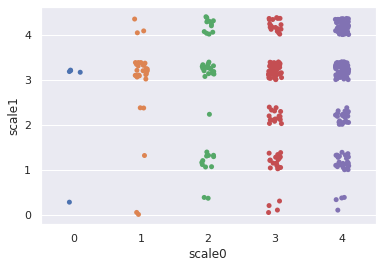

In [19]:
sns.stripplot(data=flat, x='scale0', y='scale1')

In [122]:
pooled_var = np.mean(np.sqrt(flat['scale0'] - flat['scale1']))
np.sqrt(pooled_var)

/nas/home/jwei/anaconda3/envs/notebook/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


1.025940147693396